In [3]:
from langgraph.graph import StateGraph, END

from typing import TypedDict, Annotated, Sequence,List, Union
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langgraph.prebuilt import ToolNode
import json
import re

In [4]:
import google.generativeai as genai
from google.generativeai.types import GenerationConfig

In [5]:
from langchain.tools import tool

In [ ]:

llm_json = genai.GenerativeModel(
    model_name="gemini-1.5-flash",
    generation_config=GenerationConfig(
        response_mime_type="application/json",
        temperature=0
    )
)

In [7]:
class AgentState(TypedDict):
   
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # Current stage
    stage: str 

    # Intake information
    presenting_problem: str       
    history: str                

    #  Case formulation (abc model)
    activating_event: str        
    beliefs: List[str]           
    consequences: List[str]       

  
    # LLM & Routing
    last_user_message: str            
    next_node: Union[str,bool]                   

  
    ready_to_end: bool  

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",google_api_key=GEMINI_API_KEY )


# defining nodes

In [9]:
def intake_node(self, state: AgentState) -> AgentState:
      

       
        human_messages = [msg for msg in state["messages"] if isinstance(msg, HumanMessage)]
        if not human_messages:
            raise ValueError("No user message found for intake.")

        user_input = human_messages[0].content

       
        prompt = (
            "You are a CBT assistant.\n"
            "Extract the user's presenting problem and a brief emotional history from this message:\n\n"
            f"{user_input}\n\n"
            "Respond ONLY with valid JSON in this exact format:\n"
            "{\n"
            "  \"presenting_problem\": \"...\",\n"
            "  \"history\": \"...\"\n"
            "}"
        )

        # messages = [SystemMessage(content=prompt)] + state["messages"]

    
        # response = self.llm.invoke(messages)
        response = self.llm.invoke([SystemMessage(content=prompt), HumanMessage(content=user_input)])

        
        response_content = response.content
        
        
        if isinstance(response_content, str):
            # Remove markdown code blocks if present
            json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', response_content, re.DOTALL)
            if json_match:
                response_content = json_match.group(1)
            else:
                # Try to find JSON object in the text
                json_match = re.search(r'\{.*?\}', response_content, re.DOTALL)
                if json_match:
                    response_content = json_match.group(0)
        
        # Parse the JSON
        try:
            if isinstance(response_content, dict):
                result = response_content
            else:
                result = json.loads(response_content)
        except (json.JSONDecodeError, TypeError):
            # Fallback: create a simple result
            result = {
                "presenting_problem": user_input,
                "history": "No specific history provided"
            }

        
        return {
            # "messages": messages + [response],

            "messages": [SystemMessage(content=prompt), response],
            "stage": "case_formulation_node",
            "presenting_problem": result.get("presenting_problem", ""),
            "history": result.get("history", ""),
            "activating_event": "",
            "beliefs": [],
            "consequences": [],
            "last_user_message": user_input,
            "next_node": "",
            "ready_to_end": False
        }

  

In [ ]:
# graph = StateGraph(AgentState)
# graph.add_node("intake_node", intake_node)
# graph.set_entry_point("intake_node")
# graph.set_finish_point("intake_node")


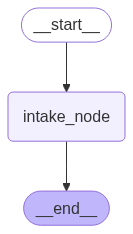

In [14]:
graph.compile()

In [ ]:
# app = graph.compile()

In [ ]:

# # Test the graph with user input
# if __name__ == "__main__":
#     user_input = "I yelled at my son today. I feel like a horrible parent."
#     messages = [HumanMessage(content=user_input)]
    
#     # Create initial state
#     initial_state = {          ##3333333???????
#         "messages": messages,
#         "stage": "intake_node",
#         "presenting_problem": "",
#         "history": "",
#         "activating_event": "",
#         "beliefs": [],
#         "consequences": [],
#         "last_user_message": "",
#         "next_node": "",
#         "ready_to_end": False
#     }
    
#     # Invoke the graph
#     print("Invoking the CBT chatbot graph...")
#     output = app.invoke(initial_state)
    
#     print("\n=== CBT Chatbot Output ===")
#     print(f"Stage: {output['stage']}")
#     print(f"Presenting Problem: {output['presenting_problem']}")
#     print(f"History: {output['history']}")
#     print(f"Last User Message: {output['last_user_message']}")
#     print(f"Ready to End: {output['ready_to_end']}")
    
#     print("\n=== Messages ===")
#     for i, msg in enumerate(output['messages']):
#         print(f"Message {i}: {type(msg).__name__} - {msg.content[:100]}...")


Invoking the CBT chatbot graph...

=== CBT Chatbot Output ===
Stage: case_formulation_node
Presenting Problem: Yelling at son; feelings of guilt and self-criticism as a parent.
History: Unspecified, requires further exploration.
Last User Message: I yelled at my son today. I feel like a horrible parent.
Ready to End: False

=== Messages ===
Message 0: HumanMessage - I yelled at my son today. I feel like a horrible parent....
Message 1: SystemMessage - You are a CBT assistant.
Extract the user's presenting problem and a brief emotional history from th...
Message 2: HumanMessage - I yelled at my son today. I feel like a horrible parent....
Message 3: AIMessage - ```json
{
  "presenting_problem": "Yelling at son; feelings of guilt and self-criticism as a parent....


In [10]:
def case_formulation_node(self, state: AgentState) -> AgentState:
        presenting_problem = state["presenting_problem"]

        prompt = (
            "You are a CBT assistant.\n"
            "Given this user's presenting problem, extract as much of the ABC model as possible:\n"
            "- A (Activating Event): what clearly happened?\n"
            "- B (Beliefs): only include if user directly stated their thoughts or judgments\n"
            "- C (Consequences): only include if emotions or actions are clearly stated\n\n"
            f"Presenting Problem:\n{presenting_problem}\n\n"
            "Respond in this EXACT format:\n"
            "{\n"
            "  \"activating_event\": \"...\",\n"
            "  \"beliefs\": [\"...\", \"...\"],\n"
            "  \"consequences\": [\"...\", \"...\"]\n"
            "}"
        )

        
        response = self.llm_json.generate_content(prompt)
        
       
        content = response.text.strip()
        
        try:
            result = json.loads(content)
        except:
            result = {}

        return {
            **state,
            # "messages": state["messages"] + [HumanMessage(content=response.text)],
            "messages": [HumanMessage(content=f'{{"activating_event": "{result.get("activating_event", "")}", "beliefs": {result.get("beliefs", [])}, "consequences": {result.get("consequences", [])}}}')],
            "stage": "goal_setting_node",
            "activating_event": result.get("activating_event", ""),
            "beliefs": result.get("beliefs", []),
            "consequences": result.get("consequences", [])
        }



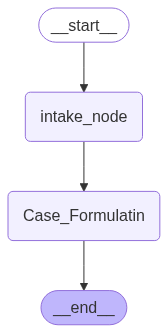

In [48]:
graph = StateGraph(AgentState)
graph.add_node("intake_node", intake_node)
graph.add_node("Case_Formulatin", case_formulation_node)

graph.set_entry_point("intake_node")
graph.add_edge("intake_node","Case_Formulatin")
graph.set_finish_point("Case_Formulatin")
graph.compile()

In [49]:
app = graph.compile()

In [ ]:

if __name__ == "__main__":
    user_input = "I yelled at my son today. I feel like a horrible parent."
    messages = [HumanMessage(content=user_input)]
    
    # Create initial state
    initial_state = {          ##3333333???????
        "messages": messages,
        "stage": "intake_node",
        "presenting_problem": "",
        "history": "",
        "activating_event": "",
        "beliefs": [],
        "consequences": [],
        "last_user_message": "",
        "next_node": "",
        "ready_to_end": False
    }
    
  
    print("Invoking the CBT chatbot graph...")
    output = app.invoke(initial_state)
    
    print("\n=== CBT Chatbot Output ===")
    print(f"Stage: {output['stage']}")
    print(f"Presenting Problem: {output['presenting_problem']}")
    print(f"History: {output['history']}")
    print(f"Last User Message: {output['last_user_message']}")
    print(f"Ready to End: {output['ready_to_end']}")
    
    print("\n=== Messages ===")
    for i, msg in enumerate(output['messages']):
        print(f"Message {i}: {type(msg).__name__} - {msg.content[:1000]}...")


Invoking the CBT chatbot graph...

=== CBT Chatbot Output ===
Stage: goal_setting_node
Presenting Problem: Yelling at son, feeling like a horrible parent
History: Unspecified, but implied negative feelings related to parenting.
Last User Message: I yelled at my son today. I feel like a horrible parent.
Ready to End: False

=== Messages ===
Message 0: HumanMessage - I yelled at my son today. I feel like a horrible parent....
Message 1: SystemMessage - You are a CBT assistant.
Extract the user's presenting problem and a brief emotional history from this message:

I yelled at my son today. I feel like a horrible parent.

Respond ONLY with valid JSON in this exact format:
{
  "presenting_problem": "...",
  "history": "..."
}...
Message 2: HumanMessage - I yelled at my son today. I feel like a horrible parent....
Message 3: AIMessage - ```json
{
  "presenting_problem": "Yelling at son, feeling like a horrible parent",
  "history": "Unspecified, but implied negative feelings related to paren

In [51]:
print(f"activating_event: {output['activating_event']}")
print(f"Belief: {output['beliefs']}")
print(f"Consequences: {output['consequences']}")


activating_event: Yelling at son
Belief: []
Consequences: ['feeling like a horrible parent']


# router node

In [11]:
def router_node(self, state: AgentState) -> AgentState:
      
        
        prompt = (
            "You are a CBT workflow assistant. Choose the next most appropriate therapeutic step.\n\n"
            "Current State:\n"
            f"Presenting Problem: {state['presenting_problem']}\n"
            f"History: {state['history']}\n"
            f"Activating Event: {state['activating_event']}\n"
            f"Beliefs: {state['beliefs']}\n"
            f"Consequences: {state['consequences']}\n"
            f"Last User Message: {state['last_user_message']}\n\n"
            "Available Options:\n"
            "- emotional_check_in: If user shows distress, negative emotions, or needs emotional support\n"
            "- psychoeducation: If user needs to understand CBT concepts or coping strategies\n"
            "- emergency_support: If there are signs of crisis, panic, or suicidal thoughts\n"
            "- problem_solving: If user is stuck or needs practical solutions\n"
            "- goal_setting_node: If ready to set therapeutic goals\n\n"
            "Respond in this EXACT format:\n"
            "{\n"
            "  \"next_node\": \"...\",\n"
            "  \"reasoning\": \"...\"\n"
            "}"
        )
        
        response = self.llm_json.generate_content(prompt)
        
        # Parse JSON response
        try:
            result = json.loads(response.text.strip())
            next_node = result.get("next_node")
            if not next_node:
                raise ValueError("Missing next_node in response")
        except:
            raise ValueError("Router failed to parse LLM response - check model configuration")
        
        # Validate the response
        valid_nodes = ["emotional_check_in", "psychoeducation", "emergency_support", "problem_solving", "goal_setting_node"]
        if next_node not in valid_nodes:
            raise ValueError(f"Invalid next_node '{next_node}' - must be one of {valid_nodes}")
        
        return {
            **state,
            "next_node": next_node,
            "stage": "router"
        }
    
   

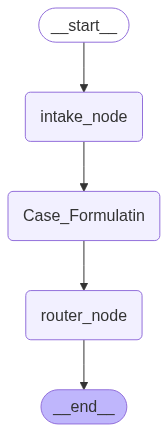

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("intake_node", intake_node)
graph.add_node("Case_Formulatin", case_formulation_node)
graph.add_node("router_node", router_node)


graph.set_entry_point("intake_node")
graph.add_edge("intake_node","Case_Formulatin")
graph.add_edge("Case_Formulatin","router_node")


graph.set_finish_point("router_node")
graph.compile()

## using different questions checking router output



In [62]:
user_input = "I yelled at my son today. I feel like a horrible parent."

user_input = "  i want to suicide"

user_input = "  what is CBT"

In [ ]:
app = graph.compile()


if __name__ == "__main__":
    user_input = user_input
    messages = [HumanMessage(content=user_input)]
    
    # Create initial state
    initial_state = {          ##3333333???????
        "messages": messages,
        "stage": "intake_node",
        "presenting_problem": "",
        "history": "",
        "activating_event": "",
        "beliefs": [],
        "consequences": [],
        "last_user_message": "",
        "next_node": "",
        "ready_to_end": False
    }
    
   
    print("Invoking the CBT chatbot graph...")
    output = app.invoke(initial_state)
    
    print("\n=== CBT Chatbot Output ===")
    print(f"Stage: {output['stage']}")
    print(f"Presenting Problem: {output['presenting_problem']}")
    print(f"History: {output['history']}")
    print(f"Last User Message: {output['last_user_message']}")
    print(f"Ready to End: {output['ready_to_end']}")
    
    print("\n=== Messages ===")
    for i, msg in enumerate(output['messages']):
        print(f"Message {i}: {type(msg).__name__} - {msg.content[:1000]}...")


Invoking the CBT chatbot graph...

=== CBT Chatbot Output ===
Stage: router
Presenting Problem: The user is seeking information about CBT, suggesting a lack of knowledge about the therapy, not necessarily a specific mental health problem.
History: No emotional history is provided.
Last User Message:   what is CBT
Ready to End: False

=== Messages ===
Message 0: HumanMessage -   what is CBT...
Message 1: SystemMessage - You are a CBT assistant.
Extract the user's presenting problem and a brief emotional history from this message:

  what is CBT

Respond ONLY with valid JSON in this exact format:
{
  "presenting_problem": "...",
  "history": "..."
}...
Message 2: HumanMessage -   what is CBT...
Message 3: AIMessage - ```json
{
  "presenting_problem": "The user is seeking information about CBT, suggesting a lack of knowledge about the therapy, not necessarily a specific mental health problem.",
  "history": "No emotional history is provided."
}
```...
Message 4: HumanMessage -   what is C

In [64]:
print(f"next_node: {output['next_node']}")



next_node: psychoeducation


###  Adding TOOLS TO EMOTIONAL_CHECK_IN STAGE

In [12]:

@tool
def run_phq9_assessment() -> dict:
    """Run PHQ-9 depression screening assessment FOR user if it is needed"""
    print("🔧 Running PHQ-9 Assessment")
    questions = [
        "Over the last 2 weeks, how often have you felt little interest or pleasure in doing things?",
        "How often have you felt down, depressed, or hopeless?",
        "How often have you had trouble falling or staying asleep?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "PHQ9", "score": score}


@tool
def run_gad7_assessment() -> dict:
    """Run GAD-7 anxiety screening assessment FOR user if it is needed"""

   

    print("🔧 Running GAD-7 Assessment")
    questions = [
        "Have you been feeling nervous or on edge?",
        "Do you find it difficult to stop worrying?",
        "Do you feel easily irritated?"
    ]
    answers = []
    for q in questions:
        print("🤖:", q)
        a = input("You: ")
        answers.append(a)
    score = sum(3 for a in answers if "yes" in a.lower() or "often" in a.lower())
    return {"tool_name": "GAD7", "score": score}


In [13]:

tools = [run_phq9_assessment, run_gad7_assessment]

llm = llm.bind_tools(tools)


In [12]:

def emotional_check_in_node(self, state: AgentState) -> AgentState:
          
            
            prompt = (
                "You are a CBT therapist doing an emotional check-in.\n\n"
                "Current State:\n"
                f"Presenting Problem: {state['presenting_problem']}\n"
                f"Consequences: {state['consequences']}\n"
                f"Last User Message: {state['last_user_message']}\n\n"
                "Provide empathetic emotional support and validate their feelings.\n"
                "Based on their emotional state, use the appropriate assessment tool if needed.\n"
                "You have access to depression and anxiety screening tools. [run_phq9_assessment, run_gad7_assessment]"
            )
            
           
            response = self.llm.invoke([HumanMessage(content=prompt)])
            
           
            print(f"\n🎯 EMOTIONAL CHECK-       NODE:")
           
            
            # Check if tools were called
            if hasattr(response, 'tool_calls') and response.tool_calls:
                for tool_call in response.tool_calls:
                    print(f"\n🔍 Running {tool_call['name']}...")
                 
            
            return {
                **state,
                "messages": state["messages"] + [response],
                "stage": "emotional_check_in",
                "next_node": True
            }

    

# next node decider

In [15]:
from langgraph.prebuilt import ToolNode

In [16]:
def decide_next_node(state:AgentState) -> AgentState:
    """This node will select the next node of the graph from router """

    return state['next_node']

In [ ]:


def should_continue(state: AgentState) -> str:
    
    messages = state["messages"]
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
    # Check if the last message has tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "continue"
    else:
        return "end"

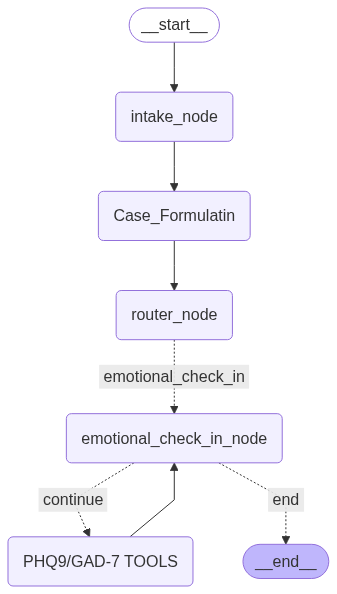

In [18]:
graph = StateGraph(AgentState)
graph.add_node("intake_node", intake_node)
graph.add_node("Case_Formulatin", case_formulation_node)
graph.add_node("router_node", router_node)
graph.add_node("emotional_check_in_node",emotional_check_in_node)


graph.set_entry_point("intake_node")
graph.add_edge("intake_node","Case_Formulatin")
graph.add_edge("Case_Formulatin","router_node")



graph.add_conditional_edges(
    "router_node",
    decide_next_node, 

    {
        # Edge: Node
      #  "psychoeducation": "pss",
        "emotional_check_in": "emotional_check_in_node",
    }

)

# ToolNode()
tool_node = ToolNode(tools=tools)
graph.add_node("PHQ9/GAD-7 TOOLS", tool_node)


# graph.add_conditional_edges(
#     "emotional_check_in_node",
#     lambda s: not s["next_node"],
#     {True: "emotional_check_in_node", False: END  }
# )



graph.add_conditional_edges(
    "emotional_check_in_node",
    should_continue,
   {
        "continue": "PHQ9/GAD-7 TOOLS",
        "end": END,

   }
)

graph.add_edge("PHQ9/GAD-7 TOOLS", "emotional_check_in_node")






graph.set_finish_point("emotional_check_in_node")
graph.compile()

In [13]:




def print_stream(stream):
    print("streaming")
    
    for s in stream:
        try:
            # if 'messages' key exists and has content
            if "messages" in s and s["messages"]:
                message = s["messages"][-1]
                
                if isinstance(message, tuple):
                    print(message)
                elif hasattr(message, 'pretty_print'):
                    message.pretty_print()
                else:
                   
                    print(f"Message: {message}")
            else:
                # Handle cases where there are no messages
                print(f"State update: {s}")
                
        except Exception as e:
            print(f"Error processing stream item: {e}")
            print(f"Stream item: {s}")
            continue

In [19]:
user_input = "I yelled at my son today. I feel like a horrible parent.  i feel low "

# user_input = "  i want to suicide"

# user_input = "  what is CBT"

In [20]:
app = graph.compile()

In [21]:
import time

In [ ]:

messages = [HumanMessage(content=user_input)]
    
    # Create initial state
initial_state = {          ##3333333???????
        "messages": messages,
        "stage": "intake_node",
        "presenting_problem": "",
        "history": "",
        "activating_event": "",
        "beliefs": [],
        "consequences": [],
        "last_user_message": "",
        "next_node": "",
        "ready_to_end": False
    }
st = app.stream(initial_state,stream_mode="values")
for s in st:
       print(s)
       time.sleep(2)  

{'messages': [HumanMessage(content='I yelled at my son today. I feel like a horrible parent.  i feel low ', additional_kwargs={}, response_metadata={})], 'stage': 'intake_node', 'presenting_problem': '', 'history': '', 'activating_event': '', 'beliefs': [], 'consequences': [], 'last_user_message': '', 'next_node': '', 'ready_to_end': False}
{'messages': [HumanMessage(content='I yelled at my son today. I feel like a horrible parent.  i feel low ', additional_kwargs={}, response_metadata={}), SystemMessage(content='You are a CBT assistant.\nExtract the user\'s presenting problem and a brief emotional history from this message:\n\nI yelled at my son today. I feel like a horrible parent.  i feel low \n\nRespond ONLY with valid JSON in this exact format:\n{\n  "presenting_problem": "...",\n  "history": "..."\n}', additional_kwargs={}, response_metadata={}), AIMessage(content='```json\n{\n  "presenting_problem": "Yelling at son; feeling like a horrible parent",\n  "history": "Feeling low"\n}

In [ ]:


# Test the graph with user input
if __name__ == "__main__":
    user_input = user_input
    messages = [HumanMessage(content=user_input)]
    
    # Create initial state
    initial_state = {          ##3333333???????
        "messages": messages,
        "stage": "intake_node",
        "presenting_problem": "",
        "history": "",
        "activating_event": "",
        "beliefs": [],
        "consequences": [],
        "last_user_message": "",
        "next_node": "",
        "ready_to_end": False
    }
    
    # Invoke the graph
    print("Invoking the CBT chatbot graph...")
    output = print_stream(app.stream(initial_state,stream_mode="values"))
    
    print("\n=== CBT Chatbot Output ==========================")
    #print(f"Stage: {output['stage']}")
    print(f"Presenting Problem: {output['presenting_problem']}")
    print(f"History: {output['history']}")
    print(f"Last User Message: {output['last_user_message']}")
    print(f"Ready to End: {output['ready_to_end']}")
    



Invoking the CBT chatbot graph...
streaming
================================ Human Message =================================

I yelled at my son today. I feel like a horrible parent.
================================== Ai Message ==================================

```json
{
  "presenting_problem": "Yelling at son, feeling like a horrible parent",
  "history": "Unspecified, but current feelings suggest potential for past difficulties with self-perception as a parent."
}
```
================================ Human Message =================================

{"activating_event": "Yelling at son", "beliefs": [], "consequences": ["feeling like a horrible parent"]}
================================ Human Message =================================

{"activating_event": "Yelling at son", "beliefs": [], "consequences": ["feeling like a horrible parent"]}

🎯 EMOTIONAL CHECK-       NODE:
================================== Ai Message ==================================

"I'm so sorry to hear that you y

TypeError: 'NoneType' object is not subscriptable

In [94]:
from Conversation_Chat import CBTChatbot

In [95]:
if __name__ == "__main__":
  
   
    chatbot = CBTChatbot(graph)
    chatbot.run_conversation()

🤖 CBT Chatbot Started
💬 Type 'quit', 'exit', or 'bye' to end the conversation
